# RHEED Simulation: MgO (001) Surface with <100> Beam

This tutorial demonstrates kinematic RHEED simulation for MgO following the approach in arXiv:2207.06642.

## Experimental Setup:
- **Crystal**: MgO (magnesium oxide, rock salt structure)
- **Surface**: (001) orientation
- **Beam direction**: <100> (along x-axis)
- **Electron energy**: 20 keV
- **Grazing angle**: 2°

## Expected Pattern:
For MgO (001) with <100> beam, we expect:
- Vertical streaks perpendicular to the beam
- Mirror symmetry about the vertical axis
- Streak spacing determined by surface reciprocal lattice

In [1]:
import jax.numpy as jnp
import rheedium as rh

### Use `autoreload` to reload changed modules, you may disable this for normal use.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
structure_file = rh.inout.parse_cif("../tests/test_data/MgO.cif")

In [4]:
structure_file

CrystalStructure(frac_positions=Array([[ 0. ,  0. ,  0. , 12. ],
       [ 0. ,  0. ,  0.5,  8. ]], dtype=float64), cart_positions=Array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.20000000e+01],
       [1.30317238e-16, 1.30317238e-16, 2.12824200e+00, 8.00000000e+00]],      dtype=float64), cell_lengths=Array([4.256484, 4.256484, 4.256484], dtype=float64), cell_angles=Array([90., 90., 90.], dtype=float64))

In [5]:
# MgO (001) surface with <100> beam direction
# The CIF file already has (001) as the surface (z-direction)
# For RHEED: beam along <100> direction (x-axis) at grazing angle

zone_axis = jnp.array([0, 0, 1])  # (001) surface normal
beam_direction = jnp.array([1, 0, 0])  # <100> beam along x-axis

# Now, load the parameters

In [6]:
# RHEED simulation parameters for MgO (001) surface, <100> beam
voltage_kV = 10.0  # Electron beam voltage in kV (typical for RHEED)
theta_deg = 2.0  # Grazing angle (1-3 degrees typical for RHEED)
phi_deg = 0.0  # Beam along x-axis (<100> direction)
hmax, kmax = 4, 4  # In-plane reciprocal lattice bounds
detector_distance = 80.0  # Detector distance in mm (typical RHEED geometry)
points_per_streak = 100  # Number of points to sample along each CTR streak

# Now, we will process things step by step.

## Electron wavelength (Å)

In [7]:
lam_ang = rh.simul.wavelength_ang(voltage_kV)
lam_ang

Array(0.12200456, dtype=float64, weak_type=True)

## Build real-space lattice vectors

In [8]:
cell_vectors = rh.ucell.build_cell_vectors(
    *structure_file.cell_lengths, *structure_file.cell_angles
)

In [9]:
cell_vectors

Array([[4.25648400e+00, 0.00000000e+00, 0.00000000e+00],
       [2.60634475e-16, 4.25648400e+00, 0.00000000e+00],
       [2.60634475e-16, 2.60634475e-16, 4.25648400e+00]], dtype=float64)

## Generate reciprocal lattice vectors

In [10]:
# For the streak simulator, we don't need to pre-generate reciprocal points
# The simulator handles CTRs internally. But we can still visualize the reciprocal lattice:
lmax = 2  # Just for visualization of bulk reciprocal lattice
Gs = rh.ucell.generate_reciprocal_points(
    crystal=structure_file, hmax=hmax, kmax=kmax, lmax=lmax, in_degrees=True
)
print(f"Reciprocal lattice points (for reference): {Gs.shape[0]}")

Reciprocal lattice points (for reference): 405


## Incident wavevector

In [11]:
k_in = rh.simul.incident_wavevector(lam_ang, theta_deg)
k_in

Array([51.46822109,  0.        , -1.79730988], dtype=float64)

## Allowed reflections by kinematic scattering conditions

In [12]:
# For discrete Bragg reflections (bulk-like), we can find allowed reflections:
tolerance = 0.1  # Tolerance for Ewald sphere intersection
allowed_indices, k_out = rh.simul.find_kinematic_reflections(
    k_in=k_in,
    gs=Gs,
    tolerance=tolerance,
)
print(f"Discrete Bragg reflections found: {len(allowed_indices)}")
print("Note: RHEED from surfaces shows streaks, not just these discrete points!")

Discrete Bragg reflections found: 5
Note: RHEED from surfaces shows streaks, not just these discrete points!


## Simulate RHEED streak pattern using Crystal Truncation Rods (CTRs)

The `streak_simulator` properly models RHEED as diffraction from a surface where
the reciprocal lattice consists of continuous rods rather than discrete points.
Each rod intersects the Ewald sphere along an arc, producing vertical streaks.

In [13]:
# Generate RHEED streak pattern for MgO (001) with <100> beam
detector_coords, intensities, hk_indices = rh.simul.streak_simulator(
    crystal=structure_file,
    voltage_kv=voltage_kV,
    theta_deg=theta_deg,
    hmax=hmax,
    kmax=kmax,
    detector_distance=detector_distance,
    points_per_streak=points_per_streak,
)

print(f"Number of streak points: {len(intensities)}")
print(f"X-coordinate range: [{detector_coords[:, 0].min():.2f}, {detector_coords[:, 0].max():.2f}] mm")
print(f"Y-coordinate range: [{detector_coords[:, 1].min():.2f}, {detector_coords[:, 1].max():.2f}] mm")

Number of streak points: 1950
X-coordinate range: [-10.37, 10.37] mm
Y-coordinate range: [0.06, 47.33] mm


## Check how many reflections were found

In [14]:
# Summary of streak pattern
print(f"Number of streak points: {len(intensities)}")
print(f"Number of unique (h,k) rods: {len(jnp.unique(hk_indices, axis=0))}")
print(f"Intensity range: [{intensities.min():.3f}, {intensities.max():.3f}]")
print("\nSample detector coordinates (first 5):")
print(detector_coords[:5])

Number of streak points: 1950
Number of unique (h,k) rods: 39
Intensity range: [0.010, 1.000]

Sample detector coordinates (first 5):
[[-10.36717427   0.46498372]
 [-10.36717427   1.39495117]
 [-10.36717427   2.32491861]
 [-10.36717427   3.25488605]
 [-10.36717427   4.1848535 ]]


## Visualize the RHEED pattern

The pattern should show vertical streaks characteristic of RHEED from (001) surface with <100> beam.

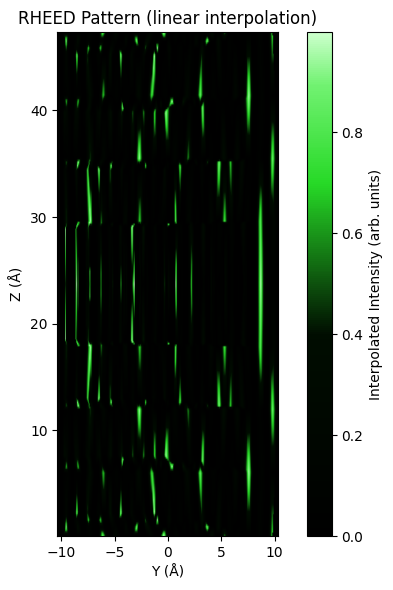

In [15]:
# Create a RHEEDPattern object for plotting
from rheedium.types import create_rheed_pattern

# The streak simulator returns coordinates, intensities, and hk indices
# We need to construct a RHEEDPattern for the plot_rheed function
streak_pattern = create_rheed_pattern(
    g_indices=jnp.arange(len(intensities), dtype=jnp.int32),  # Sequential indices
    k_out=jnp.zeros((len(intensities), 3)),  # Placeholder k_out (not used for plotting)
    detector_points=detector_coords,
    intensities=intensities,
)

# Plot using the phosphor colormap
rh.plots.plot_rheed(streak_pattern, grid_size=300, interp_type="linear")

# Understanding the MgO (001) RHEED Streak Pattern

## Physics of RHEED Streaks

Unlike bulk diffraction (discrete Bragg spots), RHEED from surfaces shows **vertical streaks** because:

1. **Surface breaks z-symmetry**: The reciprocal lattice becomes continuous rods (CTRs) along the surface normal
2. **Rods intersect Ewald sphere**: Each (h,k) rod intersects the large Ewald sphere along an arc
3. **Projection creates streaks**: These arc intersections project onto the detector as vertical lines

## Key Features:
- **Vertical streaks**: Each streak corresponds to an (h,k) CTR
- **Streak spacing**: Determined by in-plane reciprocal lattice (∝ 1/a)
- **Intensity variation**: CTR intensity varies as 1/sin²(πl), brightest at Bragg positions
- **Streak length**: Depends on Ewald sphere curvature and accessible l-range

## MgO Structure:
- Rock salt structure (fcc)
- (001) surface: square lattice with a = 4.26 Å
- For <100> beam: observe (h,0) streaks as the primary vertical features